# Student Admissions

Goal: Predict student admissions to graduate school at UCLA based on GRE Scores, GPA Scores, and class rank (1-4) 

Dataset from http://www.ats.ucla.edu/

Based on the [Predicting Student Admissions](https://github.com/udacity/aind2-dl) mini project of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data

In [2]:
data_path = 'data/student_admissions.csv'
df = pd.read_csv(data_path)
df_original = df
print(df.shape)
df.head()

(400, 4)


,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [4]:
targets = ['admit']
features = ['gre', 'gpa', 'rank']

categorical = ['admit', 'rank']
numerical = ['gre', 'gpa']

# NaN values
df.fillna(df[numerical].median(), inplace=True)       # NaN from numerical feature replaced by median
df.dropna(axis='index', how='any', inplace = True)    # NaN from categorical feature: delete row

df.shape

(399, 4)

### Visualize data

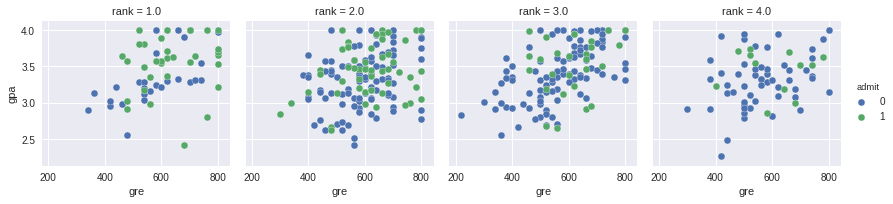

In [5]:
g = sns.FacetGrid(df, col="rank",  hue="admit")
g = (g.map(plt.scatter, "gre", "gpa", edgecolor="w")
    .add_legend())

### Dummy features

In [6]:
dummies = pd.get_dummies(df['rank'], prefix='rank', drop_first=False)
df = pd.concat([df, dummies], axis=1)
df = df.drop('rank', axis='columns')
df.head()

,admit,gre,gpa,rank_1.0,rank_2.0,rank_3.0,rank_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


### Scaling numerical features

In [7]:
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in numerical:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std
df.head()    

,admit,gre,gpa,rank_1.0,rank_2.0,rank_3.0,rank_4.0
0,0,-1.800426,0.576244,0,0,1,0
1,1,0.625329,0.734075,0,0,1,0
2,1,1.838206,1.602149,1,0,0,0
3,1,0.452061,-0.528578,0,0,0,1
4,0,-0.587548,-1.212515,0,0,0,1


### Splitting the data into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,  test_size=0.2, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train = train.drop(targets, axis=1).values, train[targets].values
x_test, y_test = test.drop(targets, axis=1).values, test[targets].values

### One-hot encoding the target

In [9]:
import keras

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("Training set: \t x-shape = {} \t y-shape = {}\n".format(x_train.shape ,y_train.shape))
print("Testing set: \t x-shape = {} \t y-shape = {}".format(x_test.shape ,y_test.shape))


Using TensorFlow backend.


Training set: 	 x-shape = (319, 6) 	 y-shape = (319, 2)

Testing set: 	 x-shape = (80, 6) 	 y-shape = (80, 2)


## Deep Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 98        
Total params: 434.0
Trainable params: 434.0
Non-trainable params: 0.0
_________________________________________________________________
Training ....
Epoch 00087: early stopping
Training: loss: 0.571 ... Training Accuracy: 0.703
Validation: loss: 0.531 ... Validation Accuracy: 0.775


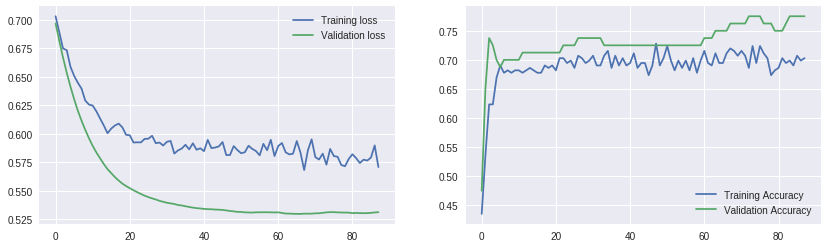

In [10]:
np.random.seed(9)
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
keras.optimizers.Adam

input_nodes = x_train.shape[1]*8
weights = keras.initializers.RandomNormal(stddev=0.1)

model = Sequential()
model.add(Dense(input_nodes, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(.2))

model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))


# opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = keras.optimizers.adam()

model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)]

print('Training ....')

history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, 
                    validation_split=0.25, callbacks=callbacks)

print("Training: loss: {:.3f} ... Training Accuracy: {:.3f}".format(
    history.history['loss'][-1], history.history['acc'][-1]))
print("Validation: loss: {:.3f} ... Validation Accuracy: {:.3f}".format(
    history.history['val_loss'][-1], history.history['val_acc'][-1]))

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
#plt.ylim(ymin=0.3, ymax=0.7)
plt.subplot(122)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
#plt.ylim(ymin=0, ymax=0.9)

## Evaluate the model

In [11]:
score = model.evaluate(x_test, y_test, verbose=1)
print(" Test Accuracy: {:.4f}".format(score[1]))

32/80 [===========>..................] - ETA: 0s Test Accuracy: 0.7500


## Make predictions

In [12]:
def predict_admission(student):
    # student_data: {id: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']}
    
    print('Admission Probabilities: \n')
    
    for key, value in student.items():
            p_name = key
            single_data = value
    
            # normalize data
            for idx, f in enumerate(numerical):
                single_data[idx] = (single_data[idx]  - scaled_features[f][0])/scaled_features[f][1]

            # make prediction
            single_pred = model.predict(np.array([single_data]))    
            print('{}: \t {:.0f}%'.format(p_name,single_pred[0,1] * 100))

In [13]:
df_original.describe()

,admit,gre,gpa,rank
count,399.000000,399.000000,399.000000,399.000000
mean,0.315789,587.819549,3.390940,2.486216
std,0.465413,115.428011,0.380152,0.945333
min,0.000000,220.000000,2.260000,1.000000
25%,0.000000,520.000000,3.130000,2.000000
50%,0.000000,580.000000,3.395000,2.000000
75%,1.000000,660.000000,3.670000,3.000000
max,1.000000,800.000000,4.000000,4.000000


In [26]:
    # student_data: {id: [gre, gpa, 'rank1, rank2, rank3, rank4]}
new_students =  {
                 'Q1 rank-1':  [730, 3.83, 1, 0, 0, 0],
                 'Q1 rank-2':  [730, 3.83, 0, 1, 0, 0],
                 'Q1 rank-3':  [730, 3.83, 0, 0, 1, 0],
                 'Q1 rank-4':  [730, 3.83, 0, 0, 0, 1],    
                 }
predict_admission(new_students)

Admission Probabilities: 

Avg rank-1: 	 51%
Avg rank-2: 	 41%
Avg rank-3: 	 26%
Avg rank-4: 	 25%
Q1 rank-1: 	 72%
Q1 rank-2: 	 49%
Q1 rank-3: 	 36%
Q1 rank-4: 	 30%
